In [1]:
import os
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.keras.backend import clear_session
from tensorflow_probability import distributions as tfd
import utilities.functions as funs

# Set the random generators for reproducibility.
os.environ['PYTHONHASHSEED']=str(12345)
random.seed(12345)
rng = np.random.default_rng(12345)
tf.random.set_seed(12345)

# Configure a new global `tensorflow` session:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-03-04 17:35:20.724934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
def mic_matrix(data):

    matrix = pd.DataFrame(columns=data.columns, index=data.columns)

    for x, y in combinations(data.columns, 2):

        # MIC (default params)
        mine = MINE() 
        mine.compute_score(data[x], data[y]) 
        matrix.loc[[x],[y]] = mine.mic()
        matrix.loc[[y],[x]] = mine.mic()

    for col in data.columns:
        # MIC (default params)
        mine = MINE() 
        mine.compute_score(data[col], data[col]) 
        matrix.loc[[col],[col]] = mine.mic()

    return matrix.apply(pd.to_numeric)

## Exploratory Data Analysis and Data Preparation
Now we start by loading the data set and doing some exploratory data analysis.

In [48]:
wine = pd.read_csv('Data/wine.csv')

In [49]:
wine.dtypes

fixed.acidity           float64
volatile.acidity        float64
citric.acid             float64
residual.sugar          float64
chlorides               float64
free.sulfur.dioxide     float64
total.sulfur.dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type                      int64
dtype: object

We will start by creating a inter feaatures correlation heatmap. Then we will show how out wines are distributed regarding quality and type. 

In [50]:
mics = mic_matrix(wine)

In [51]:
corr = wine.corr(method='spearman')

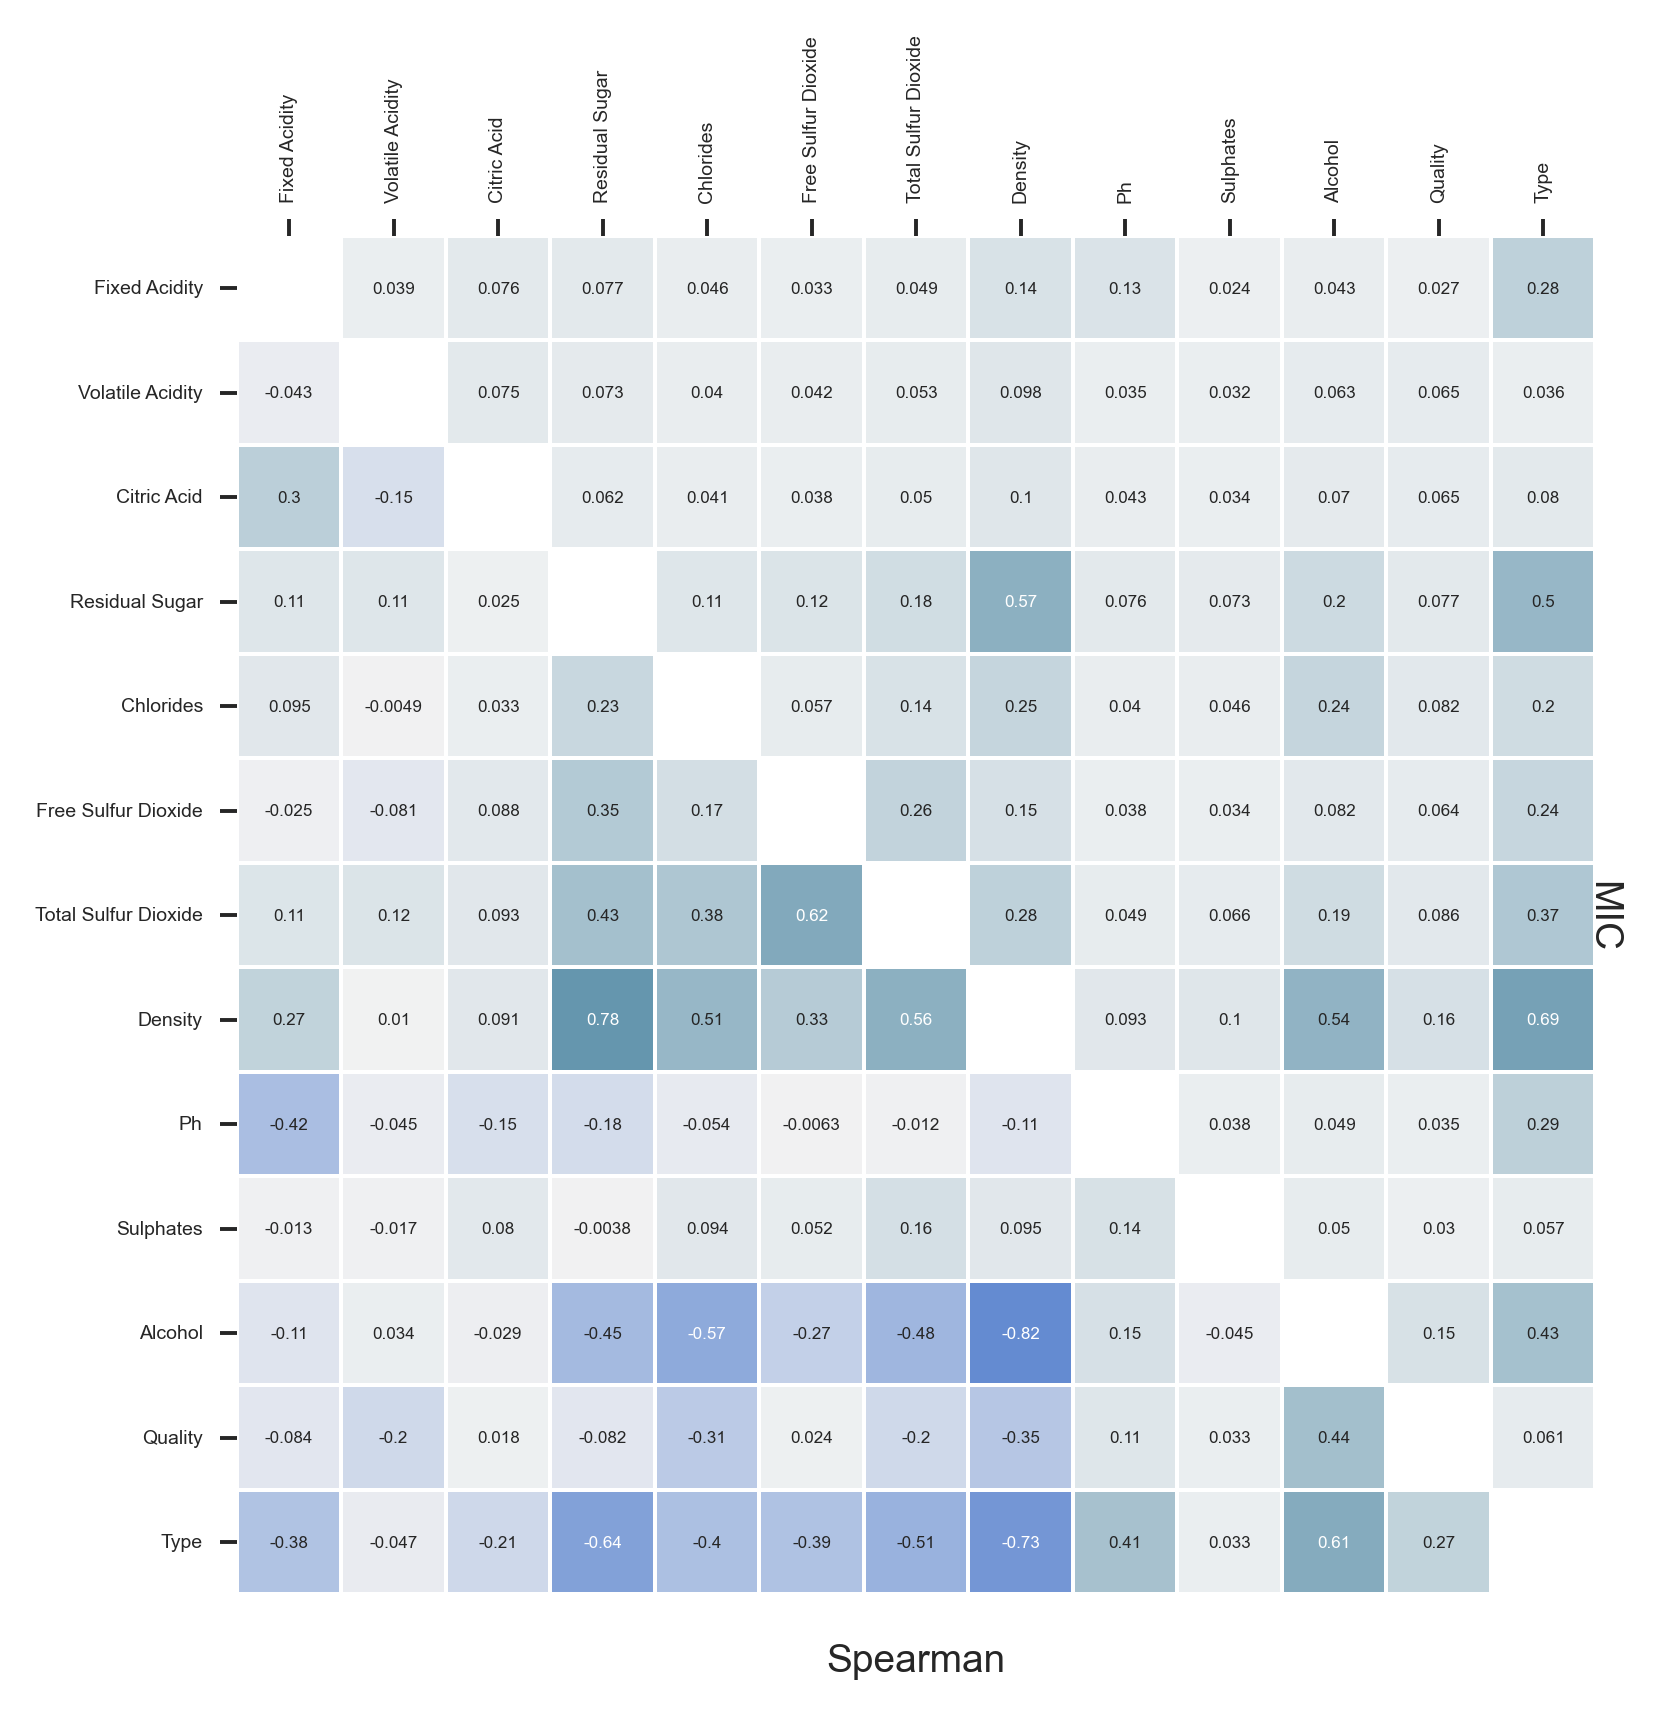

In [52]:
plt_params(350, 5, 5)
# Compute the correlation matrix.
# Generate a mask for the upper triangle.
# Generate a custom diverging colormap.
# Draw the heatmap with the mask and correct aspect ratio.

labels = [col.replace("."," ").title() for col in wine.columns]

mask_corr = np.triu(np.ones_like(corr, dtype=bool))
mask_mics = np.tril(np.ones_like(mics, dtype=bool))
cmap = sns.diverging_palette(255, 230, as_cmap=True)

fig, ax = plt.subplots(1,1)

sns.heatmap(corr, mask=mask_corr, cmap=cmap, vmax=1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": 0.5}, annot_kws={"size": 3.5}, cbar=False, ax=ax)
sns.heatmap(mics, mask=mask_mics, cmap=cmap, vmax=1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": 0.5}, annot_kws={"size": 3.5}, cbar=False, ax=ax)
# plt.title('Spearman Correlation Matrix', fontsize='xx-large', pad=15)

ax.set_xlabel("Spearman", labelpad=10, fontsize=8)
ax.set_ylabel("MIC", rotation=-90, labelpad=5, fontsize=8)

ax.set_yticklabels(labels)
ax.set_xticklabels(labels, rotation=90)
ax.tick_params(labelsize=4)

ax.xaxis.tick_top()
ax.yaxis.set_label_position("right")

plt.tight_layout()
plt.show()

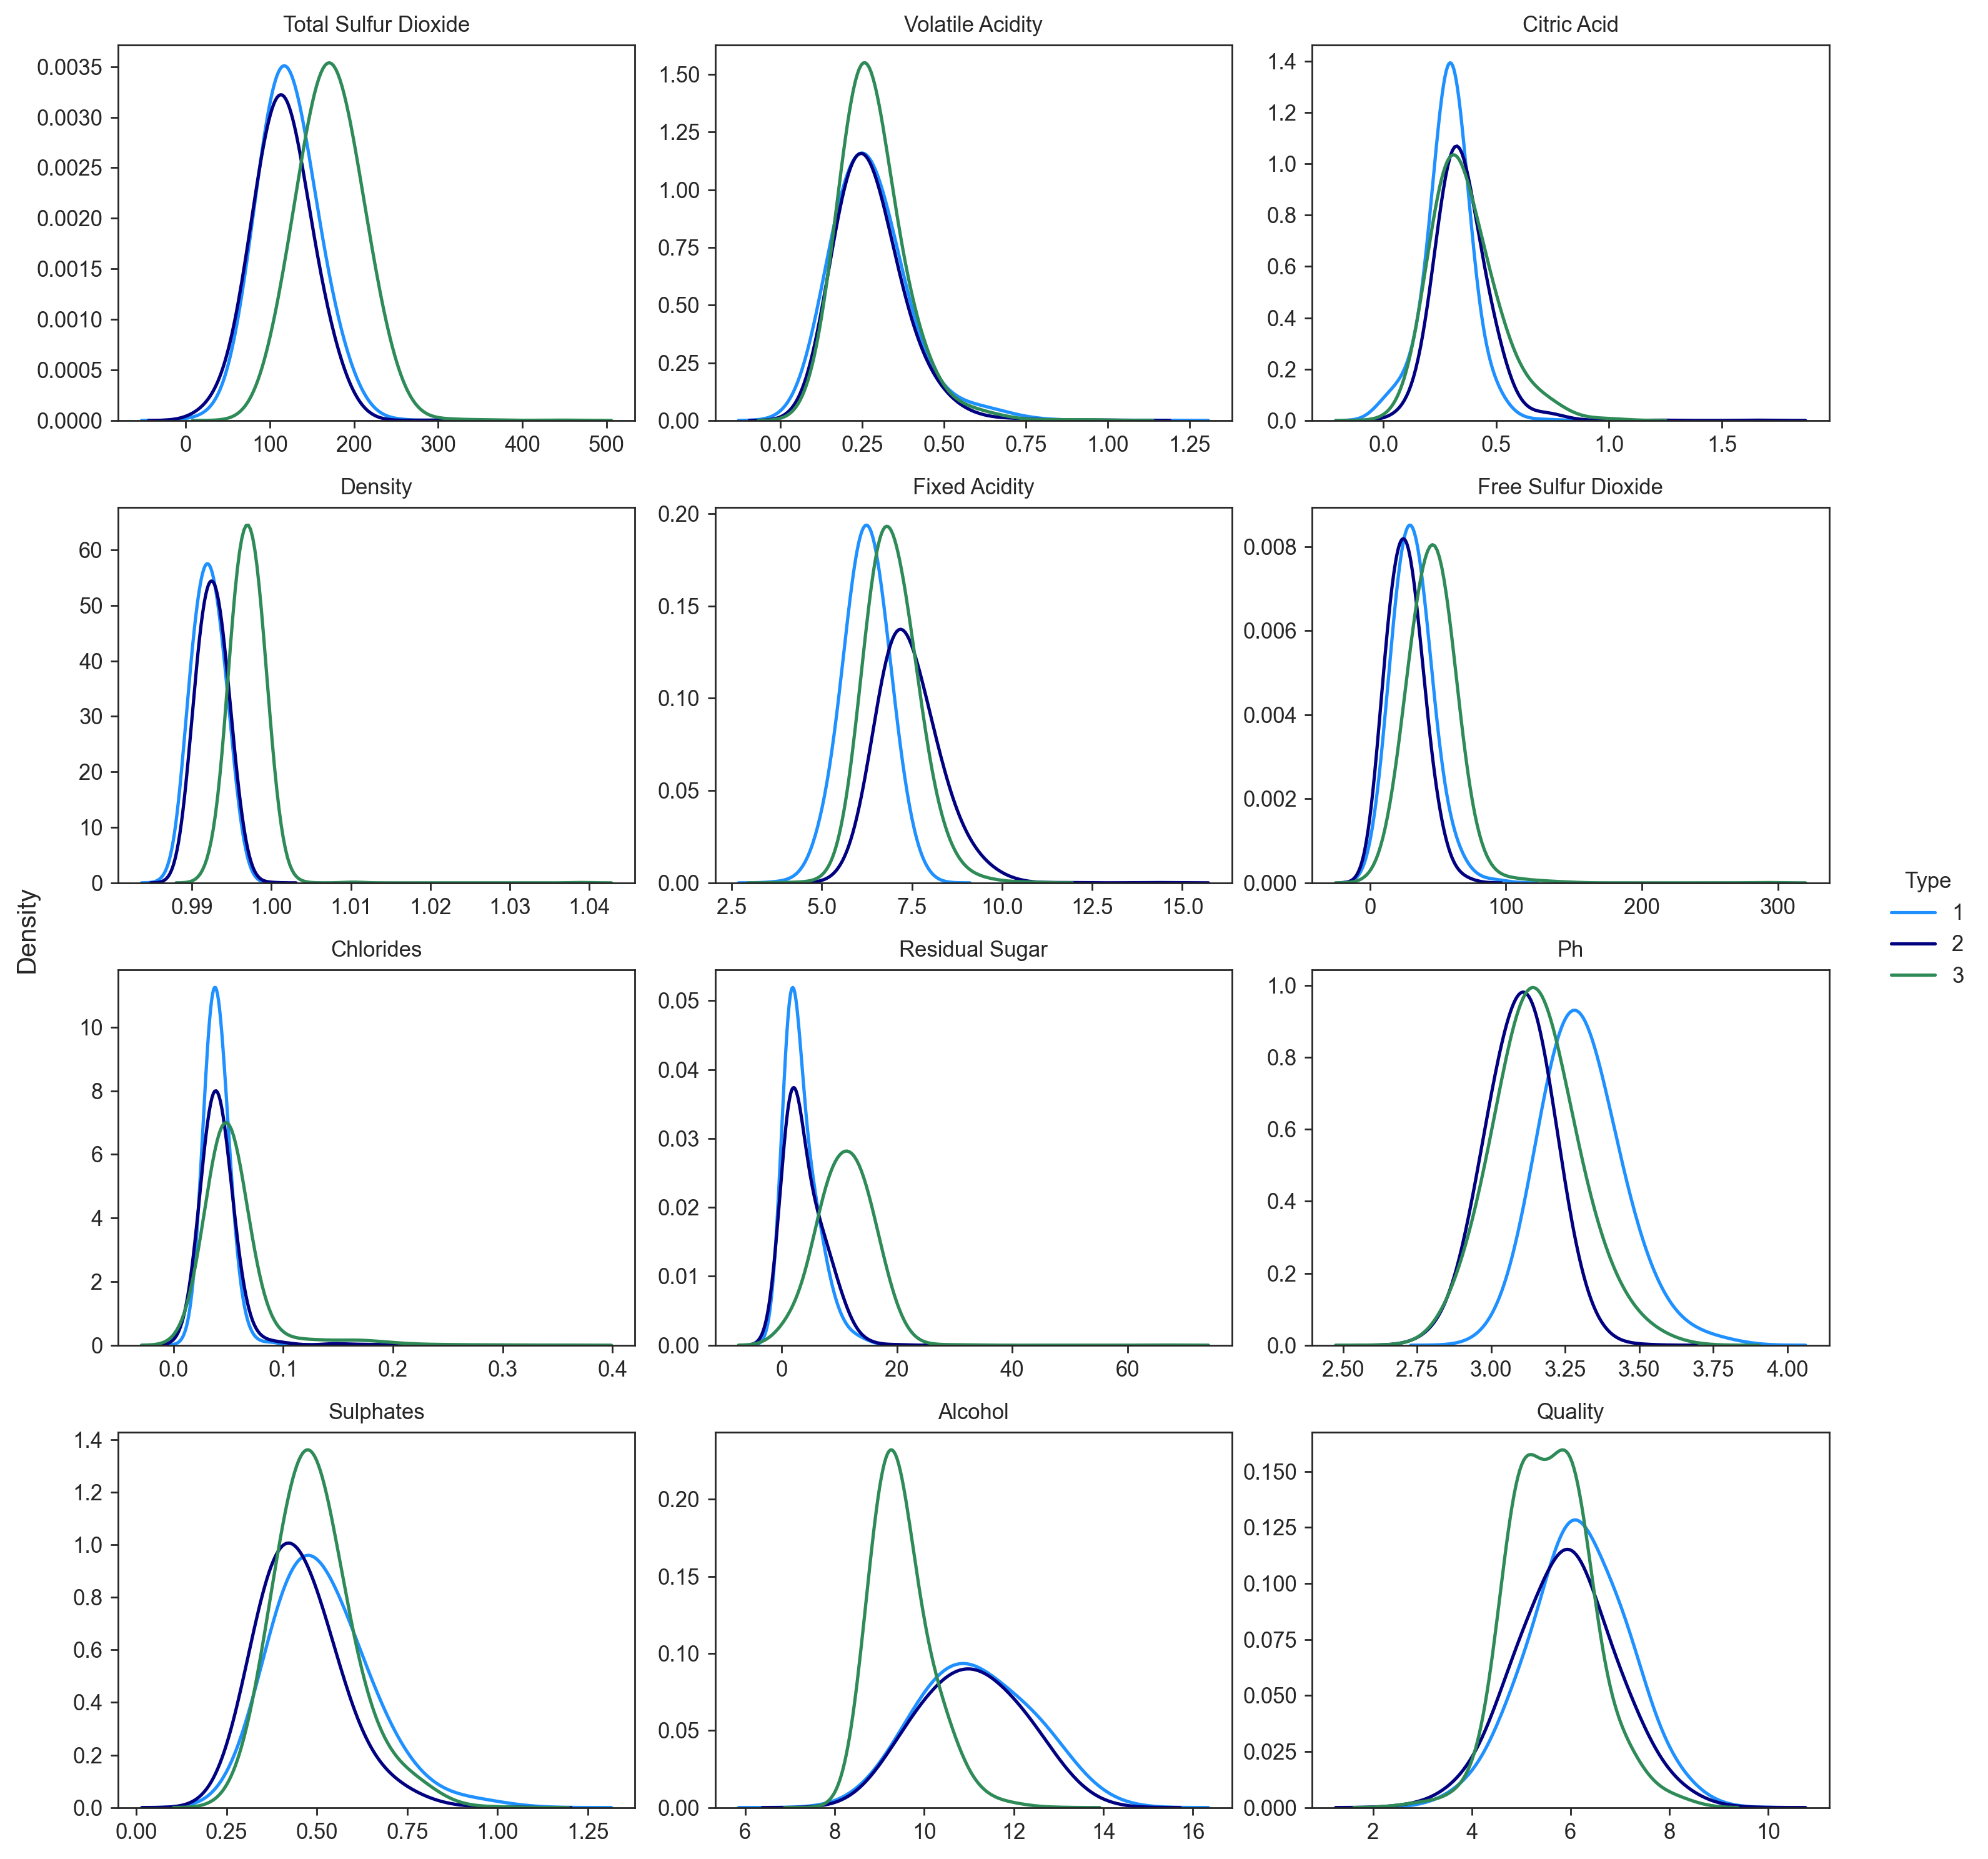

In [53]:
plt_params(250, 12, 12)

fig, axis = plt.subplots(4, 3)

cols = ['total.sulfur.dioxide','volatile.acidity','citric.acid','density',
        'fixed.acidity','free.sulfur.dioxide','chlorides','residual.sugar',
        'pH','sulphates','alcohol','quality']

i = 0 
j = 0

for var in cols:
    sns.kdeplot(data=wine, x=var, bw_adjust=2.75, common_norm=True, hue='type', legend=False, palette=my_palette1, ax=axis[i,j])
    axis[i,j].set_title(var.replace("."," ").title(), fontsize=10)
    axis[i,j].set(xlabel="", ylabel="")

    j += 1 
    if j==3: i+=1; j=0

fig.legend(title='Type', labels=["1","2","3"], loc='center right', fancybox=True, framealpha=0.0, bbox_to_anchor=(1.07,0.5))
fig.supylabel("Density", )

plt.tight_layout(h_pad=1, w_pad=0.5)
plt.show()

#### Desity Analysis

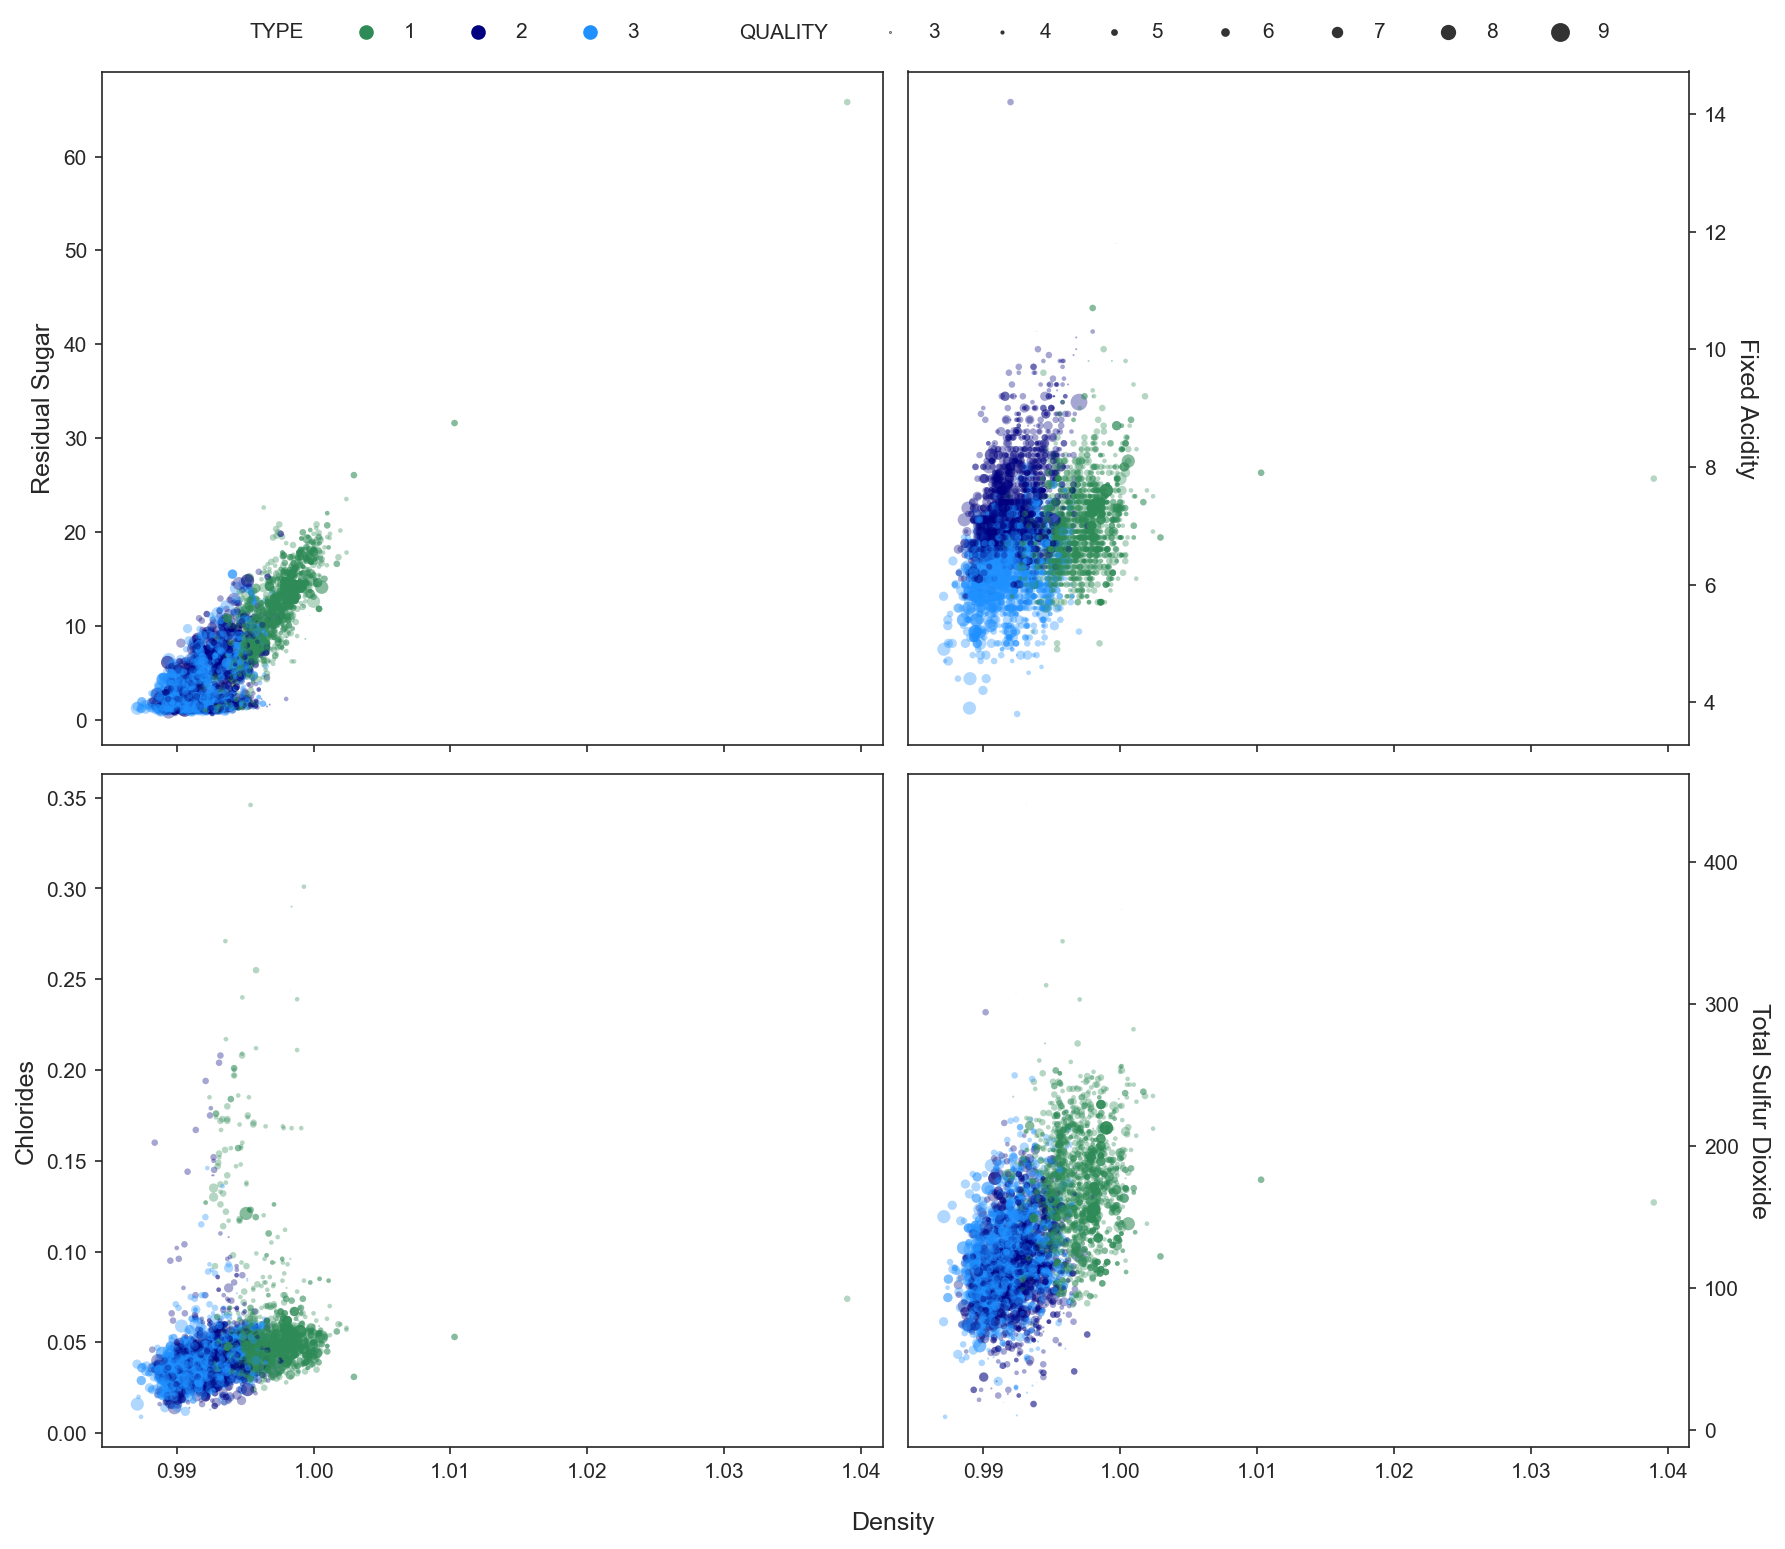

In [14]:
plt_params(150, 12, 10)

i=0; j=0
sizes =[0.1,1,5,10,20,40,65]

fig, axis = plt.subplots(2,2, sharex=True)
for var in ["residual.sugar","fixed.acidity","chlorides","total.sulfur.dioxide"]:
    sns.scatterplot(data=wine, x="density", y=var, hue="type", hue_order=[1,2,3], size="quality", sizes=sizes, edgecolor="none", palette=my_palette1, ax=axis[i,j], alpha=0.35, s=10)
    axis[i,j].get_legend().remove()
    axis[i,j].set_ylabel(var.replace("."," ").title(), fontsize=12)
    axis[i,j].set_xlabel("")
    if j==1: 
        axis[i,j].yaxis.tick_right()
        axis[i,j].yaxis.set_label_position("right")
        axis[i,j].set_ylabel(var.replace("."," ").title(), rotation=-90, labelpad=15, fontsize=12)
    
    j+=1
    if j==2:
        i+=1
        j=0
    
fig.supxlabel("Density", fontsize=12)
sns.despine(top=False, right=False)

labels, handles = axis[1,1].get_legend_handles_labels()
fig.legend(labels, [h.upper() for h in handles], loc='upper left', bbox_to_anchor=(0.10,1.03), ncol=len(labels), fancybox=True, framealpha=0.0)

plt.tight_layout()
plt.show()

#### Alcohol Analysis

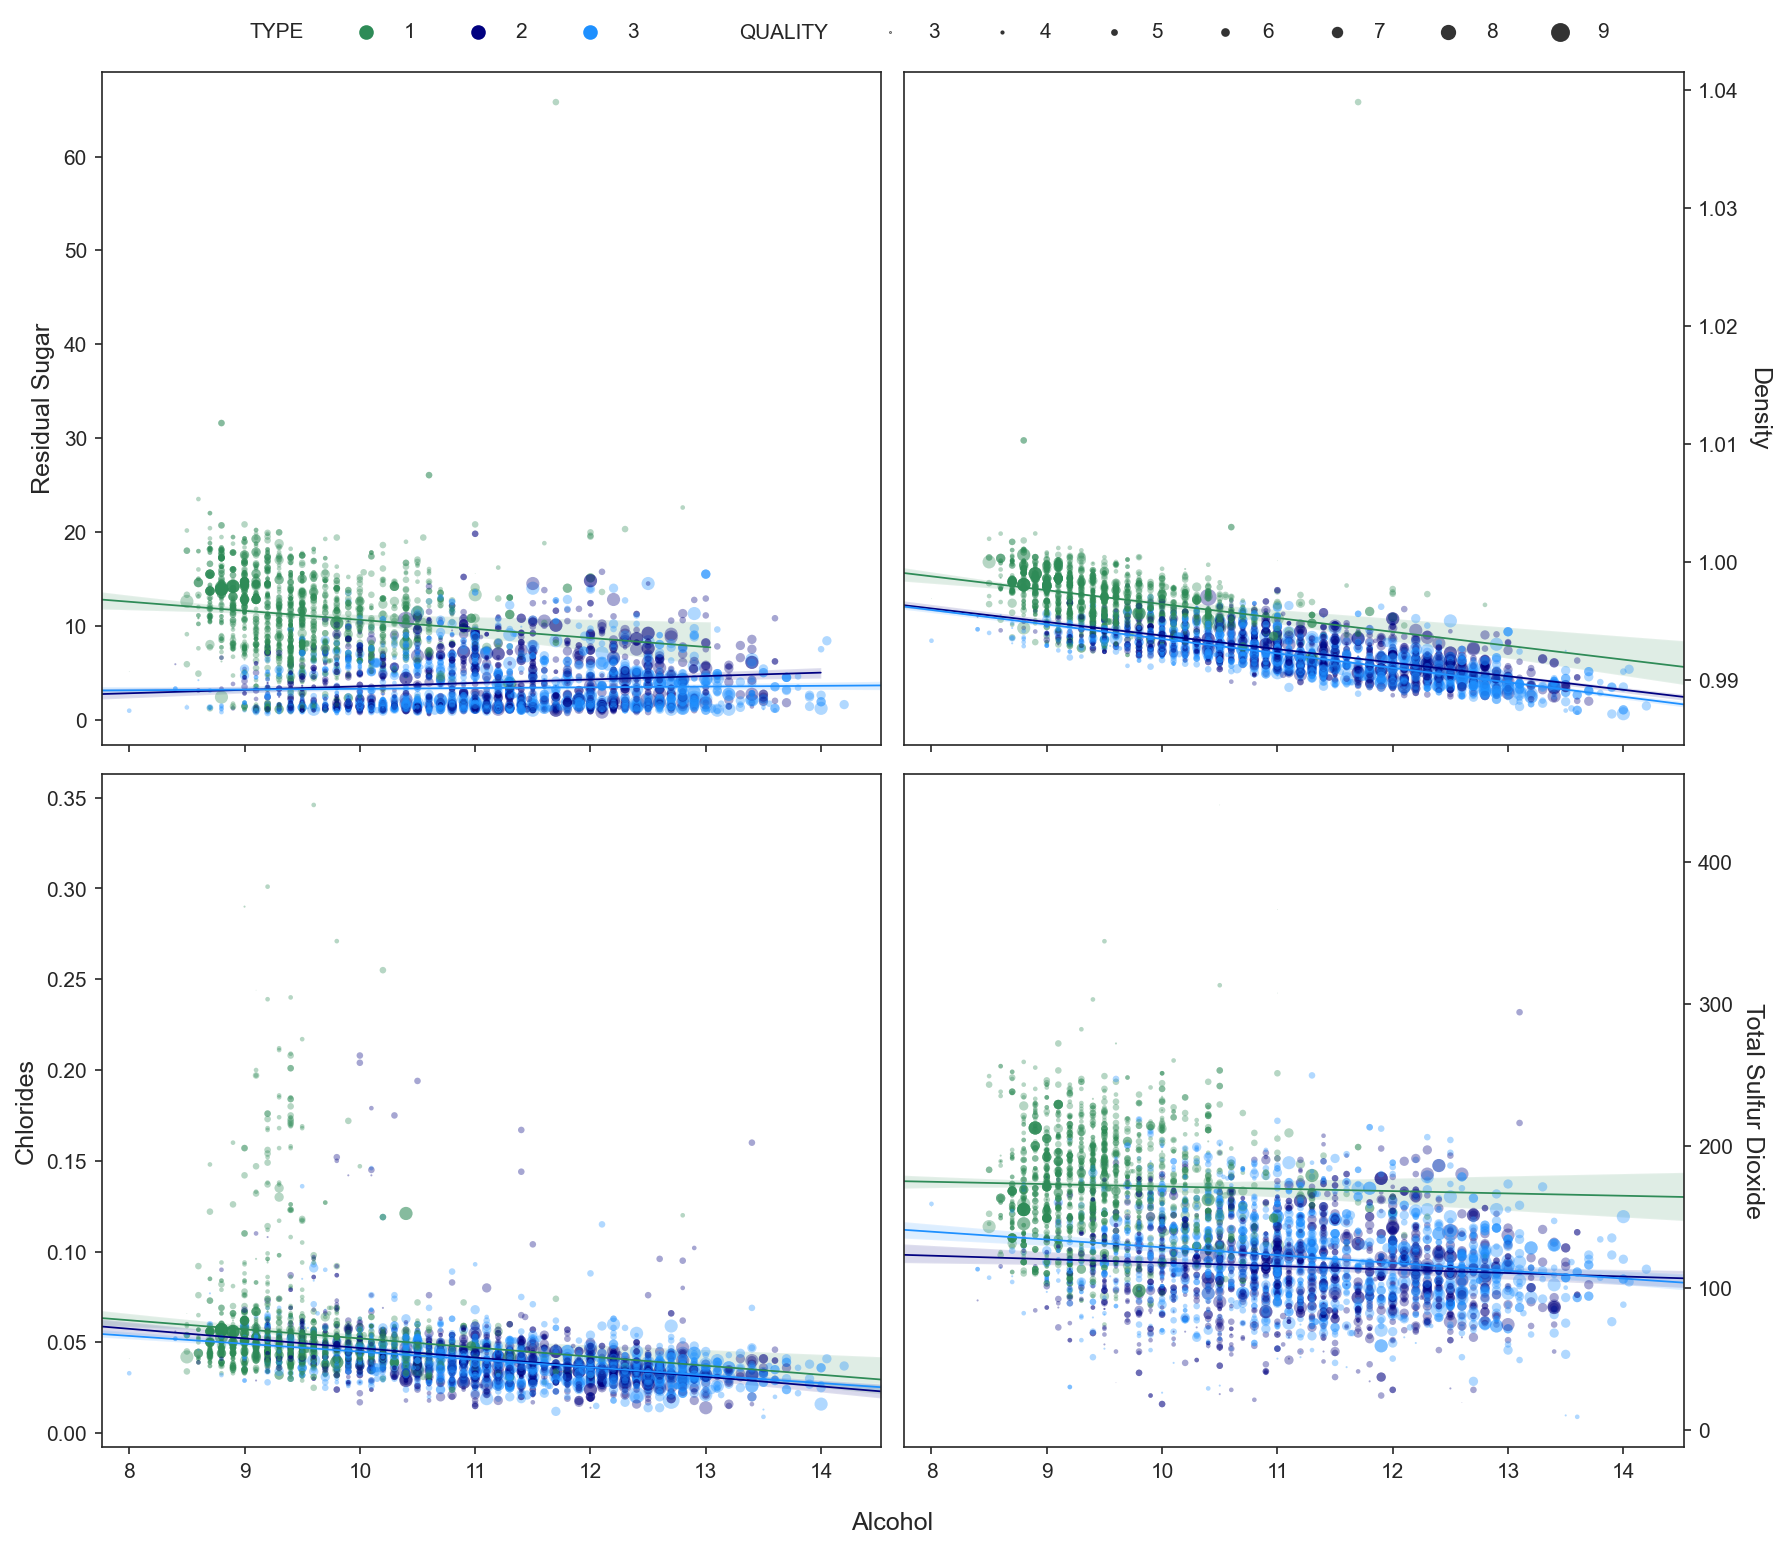

In [23]:
plt_params(150, 12, 10)

i=0; j=0
types = [1,2,3]
lkws = {"lw":0.85}
skws = {"s":0, "alpha":0.5}
sizes =[0.1,1,5,10,20,40,65]

fig, axis = plt.subplots(2,2, sharex=True)
axis.flatten()
for var in ["residual.sugar","density","chlorides","total.sulfur.dioxide"]:

    for type in types:
        subset = wine.loc[wine.type == type]
        sns.regplot(data=subset, x="alcohol", y=var, ci=99, n_boot=100, truncate=False, scatter_kws=skws, line_kws=lkws, ax=axis[i,j])
        axis[i,j].set(xlabel="", ylabel="")
    
    sns.scatterplot(data=wine, x="alcohol", y=var, hue="type", hue_order=types, size="quality", sizes=sizes, edgecolor="none", palette=my_palette1, ax=axis[i,j], alpha=0.35, s=10)
    axis[i,j].get_legend().remove()
    axis[i,j].set_ylabel(var.replace("."," ").title(), fontsize=12)
    axis[i,j].set_xlabel("")

    if j==1: 
        axis[i,j].yaxis.tick_right()
        axis[i,j].yaxis.set_label_position("right")
        axis[i,j].set_ylabel(var.replace("."," ").title(), rotation=-90, labelpad=15, fontsize=12)
    
    j+=1
    if j==2:
        i+=1
        j=0
    
fig.supxlabel("Alcohol")
sns.despine(top=False, right=False)
labels, handles = axis[1,1].get_legend_handles_labels()
fig.legend(labels, [h.upper() for h in handles], loc='upper left', bbox_to_anchor=(0.10,1.03), ncol=len(labels), fancybox=True, framealpha=0.0)

plt.tight_layout()
plt.show()

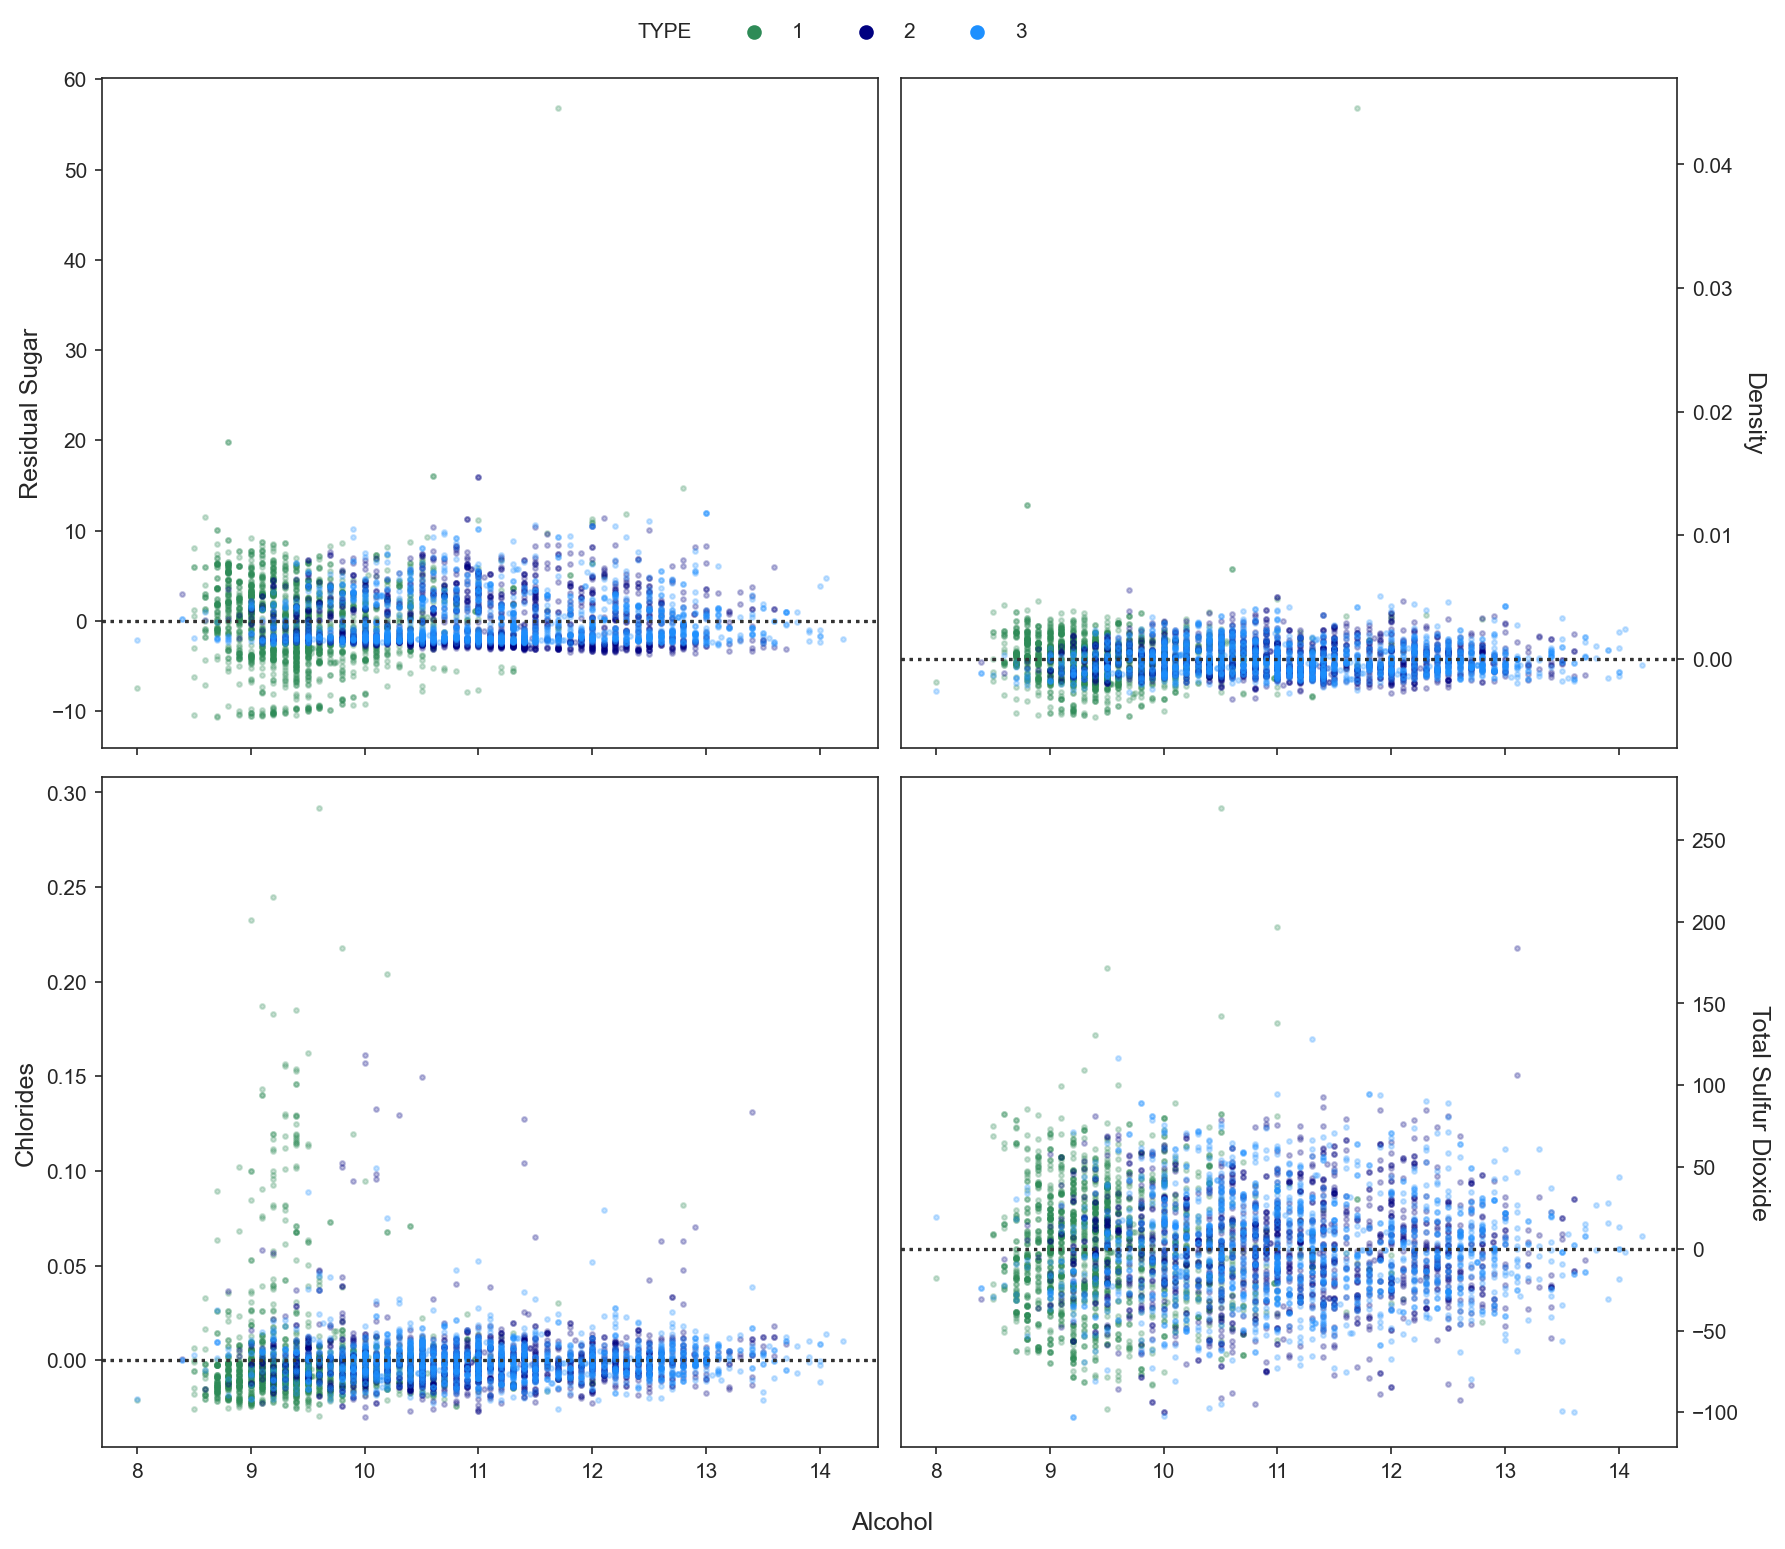

In [40]:
plt_params(150, 12, 10)

i=0; j=0
types = [1,2,3]
lkws = {"lw":0.85, "ls":"--"}
skws = {"s":5, "alpha":0.25}

fig, axis = plt.subplots(2,2, sharex=True)
axis.flatten()

for var in ["residual.sugar","density","chlorides","total.sulfur.dioxide"]:
    for type in types:
        subset = wine.loc[wine.type == type]
        sns.residplot(data=subset, x="alcohol", y=var, scatter_kws=skws, line_kws=lkws, ax=axis[i,j])
        axis[i,j].set(xlabel="", ylabel="")
    
    axis[i,j].set_ylabel(var.replace("."," ").title(), fontsize=12)
    axis[i,j].set_xlabel("")

    if j==1: 
        axis[i,j].yaxis.tick_right()
        axis[i,j].yaxis.set_label_position("right")
        axis[i,j].set_ylabel(var.replace("."," ").title(), rotation=-90, labelpad=15, fontsize=12)
    
    j+=1
    if j==2:
        i+=1
        j=0
    
fig.supxlabel("Alcohol")
sns.despine(top=False, right=False)
fig.legend(labels[0:4], [h.upper() for h in handles[0:4]], loc='upper center', bbox_to_anchor=(0.45,1.03), ncol=len(labels), fancybox=True, framealpha=0.0)

plt.tight_layout()
plt.show()

#### Fixed Acidity Analysis

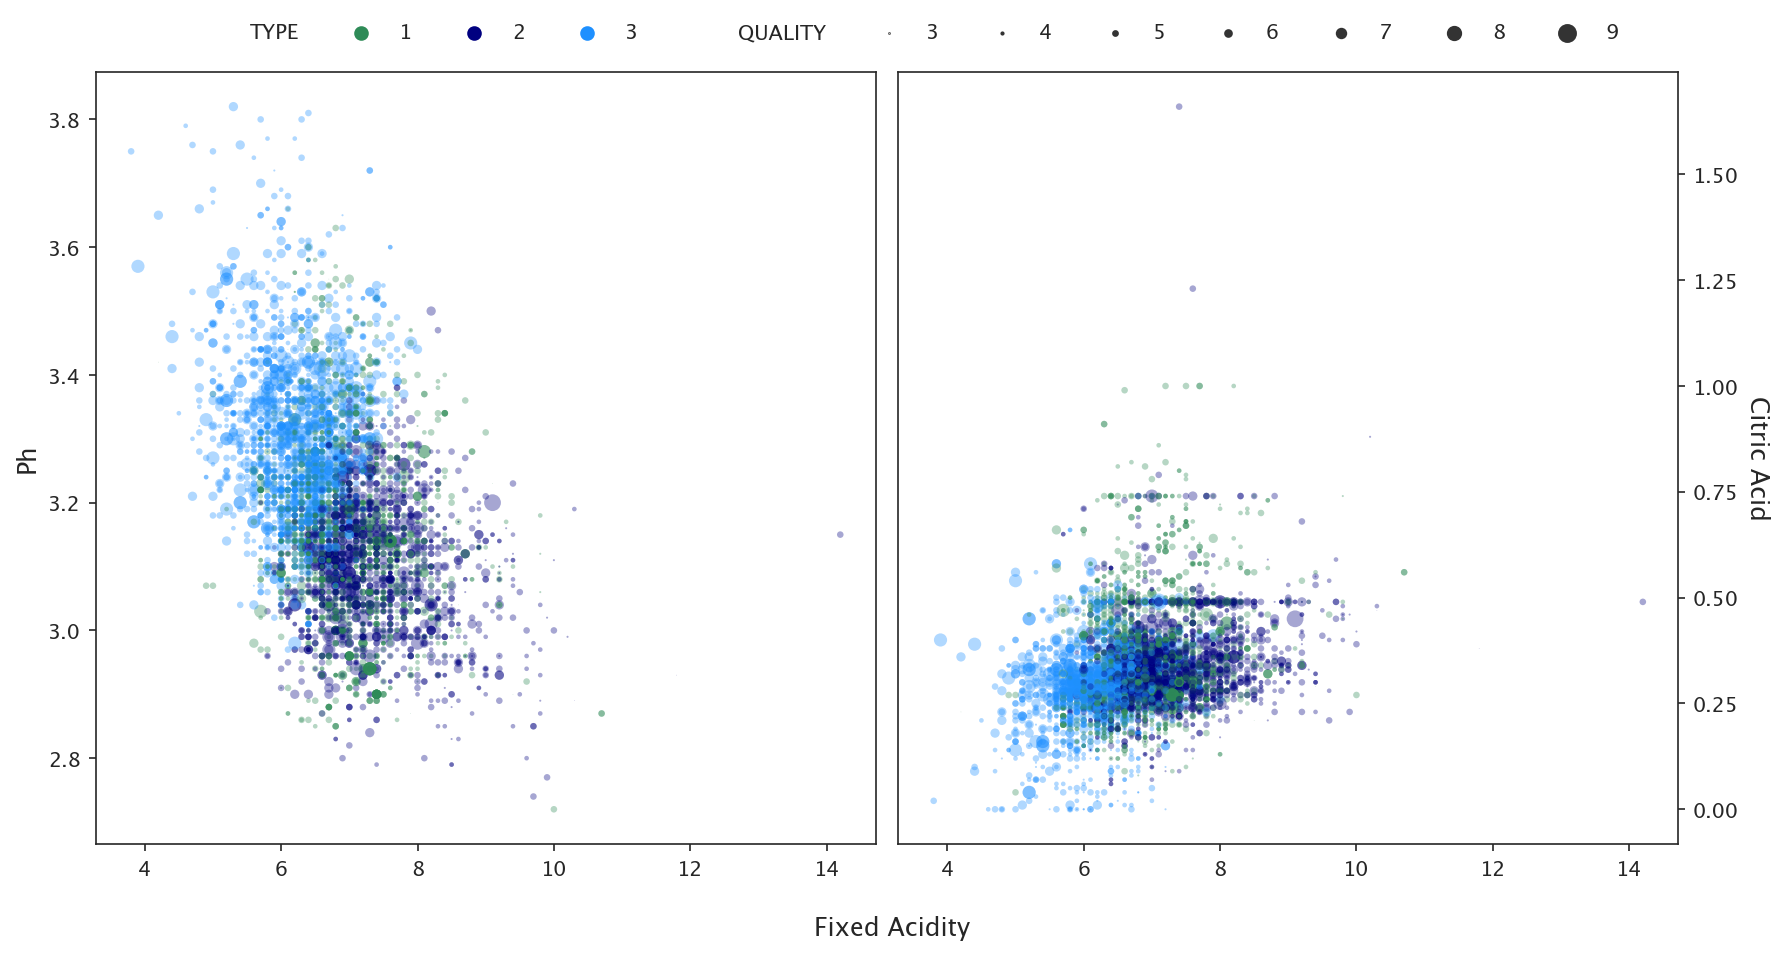

In [64]:
plt_params(150, 12, 6)

i=0; j=0
sizes =[0.1,1,5,10,20,40,65]

fig, axis = plt.subplots (1,2, sharex=True)
for i, var in enumerate(["pH","citric.acid"]):
    sns.scatterplot(data=wine, x="fixed.acidity", y=var, hue="type", size="quality", sizes=sizes, hue_order=["1","2","3"], edgecolor="none", ax=axis[i], alpha=0.35)
    axis[i].get_legend().remove()
    axis[i].set_ylabel(var.replace("."," ").title(), fontsize=12)
    axis[i].set_xlabel("")
    if i==1: 
        axis[i].yaxis.tick_right()
        axis[i].yaxis.set_label_position("right")
        axis[i].set_ylabel(var.replace("."," ").title(), rotation=-90, labelpad=15, fontsize=12)
    
fig.supxlabel("Fixed Acidity")
sns.despine(top=False, right=False)
labels, handles = axis[1].get_legend_handles_labels()
fig.legend(labels, [h.upper() for h in handles], loc='upper left', bbox_to_anchor=(0.10,1.05), ncol=len(labels), fancybox=True, framealpha=0.0)

plt.tight_layout()
plt.show()

/Users/rodrigocardenasdominguez/opt/anaconda3/envs/DS/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


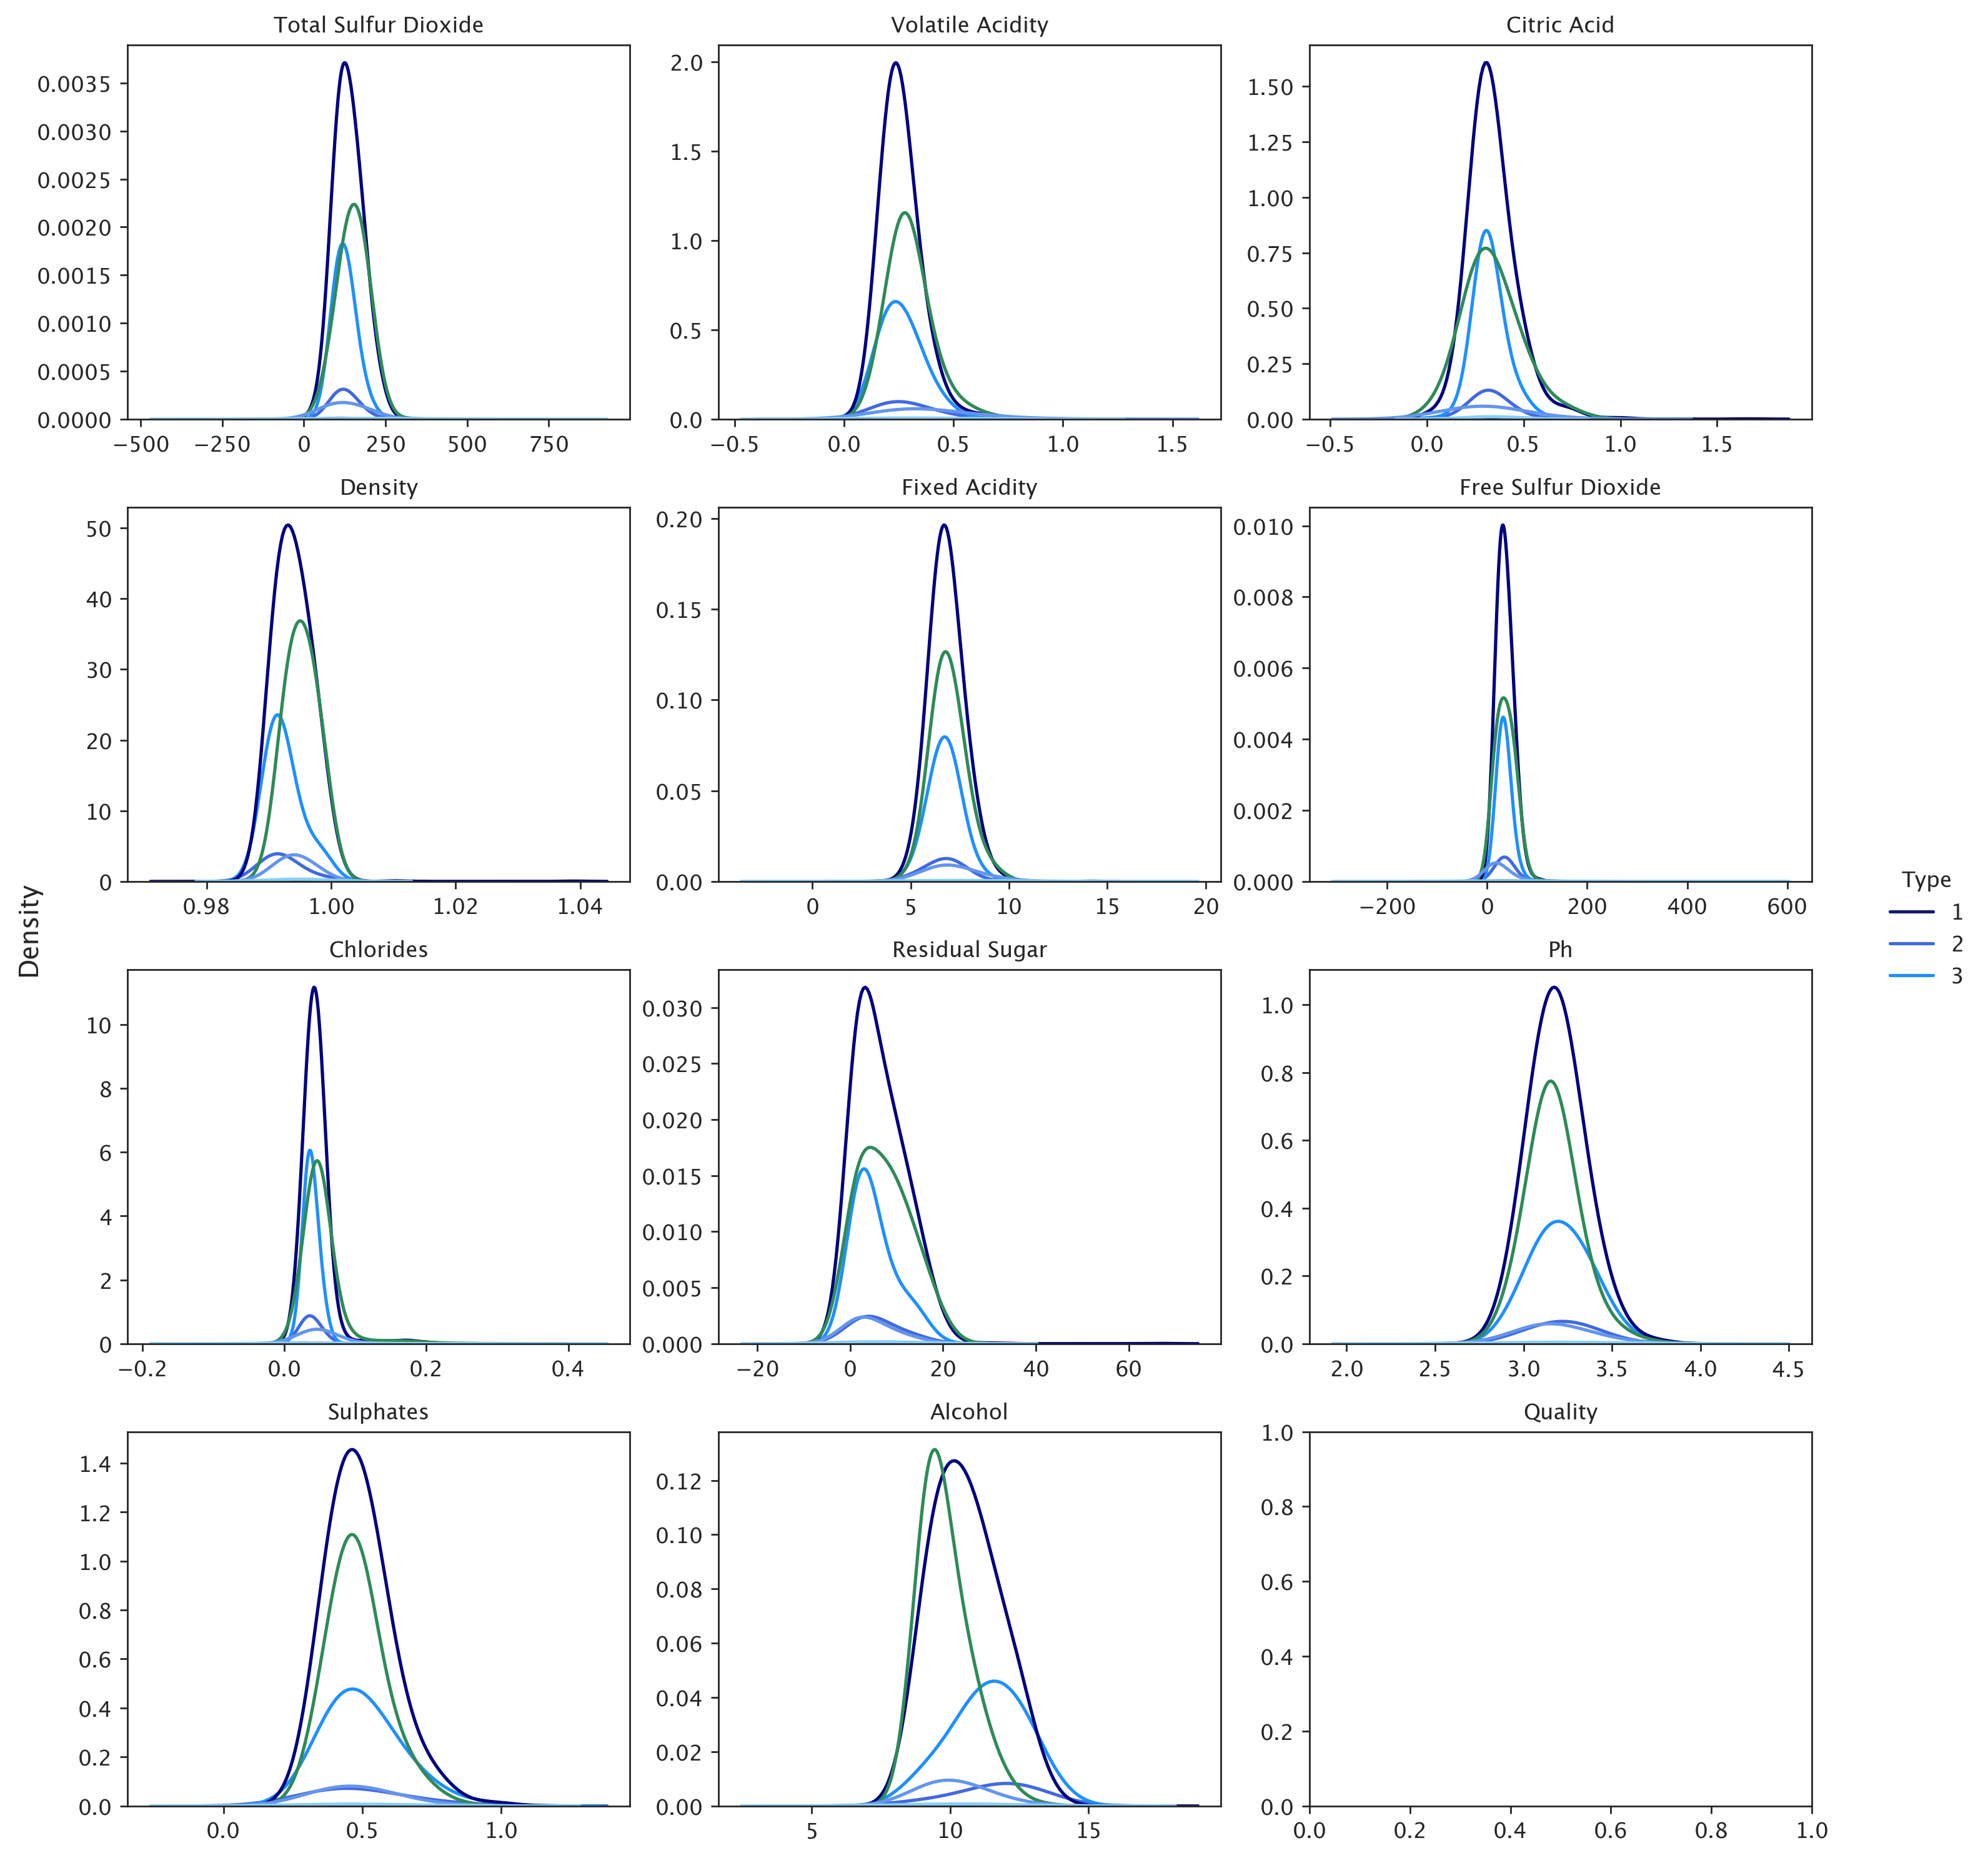

In [136]:
plt_params(250, 12, 12)

fig, axis = plt.subplots(4, 3)

cols = ['total.sulfur.dioxide','volatile.acidity','citric.acid','density',
        'fixed.acidity','free.sulfur.dioxide','chlorides','residual.sugar',
        'pH','sulphates','alcohol','quality']

i = 0 
j = 0

for var in cols:
    sns.kdeplot(data=wine, x=var, bw_adjust=2.75, common_norm=True, hue='quality', legend=False, palette=my_palette2, ax=axis[i,j])
    # sns.histplot(data=wine, x=var, hue="type", stat="density", bins=40, kde=True, kde_kws={"bw_adjust":2}, ax=axis[i,j])
    # sns.violinplot(data=wine, x=var, y="type", bw=1, width=0.5, linewidth=0.5, ax=axis[i,j])
    # sns.boxplot(data=wine, x=var, y="type", width=0.55, fliersize=1, linewidth=1, saturation=0.25, ax=axis[i,j])
    # sns.stripplot(data=wine, x=var, y="type", size=1, ax=axis[i,j])
    # axis[i,j].legend(title="Type", labels=["1","2","3"], loc='upper right', fancybox=True, framealpha=0.0, fontsize='small')
    axis[i,j].set_title(var.replace("."," ").title(), fontsize=10)
    axis[i,j].set(xlabel="", ylabel="")

    j += 1 
    if j==3: i+=1; j=0

# sns.move_legend(axis[1,2], "upper left", bbox_to_anchor=(1, 1))
fig.legend(title='Type', labels=["1","2","3"], loc='center right', fancybox=True, framealpha=0.0, bbox_to_anchor=(1.07,0.5))
fig.supylabel("Density", )

plt.tight_layout(h_pad=1, w_pad=0.5)
plt.show()